In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re
import urllib.request
import mecab
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/finance_sentiment_corpus/main/finance_data.csv", filename="finance_data.csv")

('finance_data.csv', <http.client.HTTPMessage at 0x22a6be9a9d0>)

# Data Load

## 금융데이터

In [3]:
data = pd.read_csv('finance_data.csv')
print('총 샘플의 수 :',len(data))

총 샘플의 수 : 4846


In [4]:
data['labels'] = data['labels'].replace(['neutral', 'positive', 'negative'],[0, 1, 2])
data[:2]

,labels,sentence,kor_sentence
0,0,"According to Gran, the company has no plans to...","Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로..."
1,0,Technopolis plans to develop in stages an area...,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...


In [5]:
del data['sentence']

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   labels        4846 non-null   int64 
 1   kor_sentence  4846 non-null   object
dtypes: int64(1), object(1)
memory usage: 75.8+ KB


In [7]:
print('결측값 여부 :',data.isnull().values.any())

결측값 여부 : False


In [8]:
print('kor_sentence 열의 유니크한 값 :',data['kor_sentence'].nunique())

kor_sentence 열의 유니크한 값 : 4827


In [9]:
duplicate = data[data.duplicated()]

In [10]:
duplicate

,labels,kor_sentence
1099,0,이 발표 내용에 대한 책임은 전적으로 발행자에게 있습니다.
1394,0,"핀란드 헬싱키에 본사를 둔 레민카이넨 그룹은 토목 공학, 건축 계약, 기술 건축 서..."
1416,0,"이 보고서는 블랙 앤 데커, 피스카스, 피스카스 브랜드, 후스크바르나 아웃도어 프로..."
2396,0,알스트롬의 주가는 나스닥 OMX 헬싱키에서 인용되고 있다.
2567,0,SSH 통신 보안 코퍼레이션은 핀란드 헬싱키에 본사를 두고 있다.
2889,0,재정적인 세부사항은 공개되지 않았다.
2890,0,재정적인 세부사항은 공개되지 않았다.
2892,0,금융 조건은 공개되지 않았다.
3050,0,재정적인 세부사항은 제공되지 않았다.
3051,0,재정적인 세부사항은 공개되지 않았다.


In [11]:
# 중복 제거
data.drop_duplicates(subset=['kor_sentence'], inplace=True)
print('총 샘플의 수 :',len(data))

총 샘플의 수 : 4827


<AxesSubplot: >

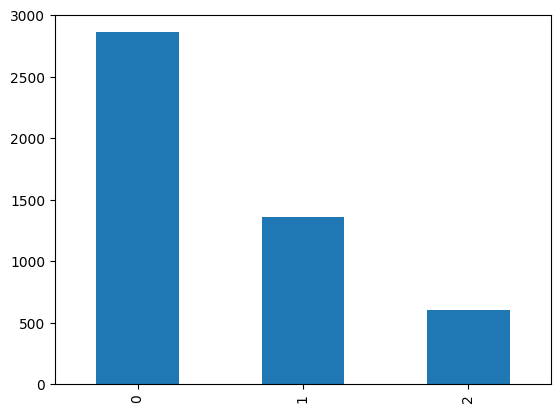

In [12]:
data['labels'].value_counts().plot(kind='bar')

In [13]:
print('레이블의 분포')
print(data.groupby('labels').size().reset_index(name='count'))

레이블의 분포
   labels  count
0       0   2861
1       1   1362
2       2    604


In [14]:
print(f'중립의 비율 = {round(data["labels"].value_counts()[0]/len(data) * 100,3)}%')
print(f'긍정의 비율 = {round(data["labels"].value_counts()[1]/len(data) * 100,3)}%')
print(f'부정의 비율 = {round(data["labels"].value_counts()[2]/len(data) * 100,3)}%')

중립의 비율 = 59.271%
긍정의 비율 = 28.216%
부정의 비율 = 12.513%


In [15]:
mecab = mecab.MeCab()

In [16]:
data['tokenized'] = data['kor_sentence'].apply(mecab.morphs)

In [17]:
data = data[['labels','tokenized']]

In [18]:
data.head(2)

,labels,tokenized
0,0,"[Gran, 에, 따르, 면, ,, 그, 회사, 는, 회사, 가, 성장, 하, 고,..."
1,0,"[테크노폴리스, 는, 컴퓨터, 기술, 과, 통신, 분야, 에서, 일, 하, 는, 회..."


## 뉴스데이터

In [19]:
path = '..\데이터\기업별 뉴스'

In [20]:
import os
file_list = os.listdir(path)
len(file_list)

140

In [21]:
file_name = []
for file in file_list:
    if file.count(".") == 1: 
        name = file.split('.')[0]
        file_name.append(name)
    # else:
    #     for k in range(len(file)-1,0,-1):
    #         if file[k]=='.':
    #             file_name.append(file[:k])
    #             break

In [22]:
file_name[:5]

['CMG제약', 'HLB생명과학', 'JW생명과학', 'JW신약', 'JW중외제약']

In [23]:
df1 = []
for 기업 in file_name:
    df =pd.read_excel(f"../데이터/기업별 뉴스/{기업}.xlsx",sheet_name='#02 Documents')#,header=0,skiprows=[1,2])
    # df = df[['Unnamed: 2','20221231','20211231','20201231','20191231','20181231']]
    df = pd.DataFrame(df)
    df1.append(df)
len(df1)

140

In [24]:
df2 =[]
for df in df1:
    df = df[['title','polarity.label']]
    df['polarity.label'] = df['polarity.label'].replace(-1,2)
    # dupli = df[df.duplicated()]
    df.drop_duplicates(subset=['title'], inplace=True)
    df2.append(df)
    # duplicate_list.append(dupli)

In [25]:
len(df2)

140

In [26]:
df2[49].head(2)

,title,polarity.label
0,[취재 일지]세계는 여전히 ‘건기식’ 열풍… 경쟁력 높이려면 식약처 기준 완화돼야,NaN
1,"어린이 프로바이오틱스, 유산균도 가격도 천차만별…따져보고 사야",NaN


In [27]:
train = []
test  = []
for df in df2:
    tmp_train = df[df['polarity.label'].notna()]
    tmp_test = df[df['polarity.label'].isna()]
    train.append(tmp_train)
    test.append(tmp_test)

In [28]:
len(train), len(test)

(140, 140)

In [29]:
# train

In [34]:
train1 =[]
for df in train:
    df['tokenized'] = df['title'].apply(mecab.morphs)
    df['labels'] = df['polarity.label']
    df = df[['labels','tokenized']]
    train1.append(df)

In [35]:
train1[0].head(2)

,labels,tokenized
2,1.0,"[한독, ,, 당뇨, 치료, ·, 항염증제, 이, 을, 새, 성장, 동력, 은, ?]"
3,1.0,"[CMG, 제약, ', 차, 앤, 맘, ',, 2023, SCWC, 사랑, 의, 바..."


## concat

In [36]:
train_df = pd.concat(train1, axis = 0)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18038 entries, 2 to 408
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   labels     18038 non-null  float64
 1   tokenized  18038 non-null  object 
dtypes: float64(1), object(1)
memory usage: 422.8+ KB


In [37]:
final_df = pd.concat([train_df,data],axis = 0)
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22865 entries, 2 to 4845
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   labels     22865 non-null  float64
 1   tokenized  22865 non-null  object 
dtypes: float64(1), object(1)
memory usage: 535.9+ KB


# train-test

In [38]:
X = final_df['tokenized']
y = final_df['labels']

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [40]:
X_train.shape,X_test.shape,y_train.shape, y_test.shape

((18292,), (4573,), (18292,), (4573,))

In [53]:
X_train.to_csv('./X_train.csv')
X_test.to_csv('./X_test.csv')

# 토크나이즈

In [41]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_encoded = tokenizer.texts_to_sequences(X_train)
X_test_encoded = tokenizer.texts_to_sequences(X_test)
print(X_train_encoded[:5])
print(X_test_encoded[:5])

[[84, 26, 219, 40, 39, 3628, 3332, 366, 1659, 10, 99, 3088, 18, 1101, 9977, 805, 43, 3332, 9978, 789], [7, 38, 60, 27, 32, 377, 25, 8, 362, 4, 9979, 9, 2423, 1, 5910, 17, 68, 1717, 9980, 9981, 99, 66, 117, 43], [7, 46, 19, 8, 1184, 553, 9, 346, 1, 27, 62, 55, 142, 790, 4, 27, 24, 130, 106], [136, 278, 1907, 72, 1, 196, 627, 144, 122, 2054, 17, 33, 4, 160], [70, 6, 722, 61, 144, 52, 2704, 1065, 423, 5, 353, 21, 186, 32, 246, 25, 1234, 6, 196, 227, 52, 2704, 1065, 47, 1354, 1, 3333, 2, 49, 29, 1608, 16, 3629, 139, 396, 14, 196, 347, 76, 72, 4, 66, 3981, 2275, 280, 30, 232, 722, 30, 99, 23, 5, 66, 16, 415, 34, 155, 199, 11, 2]]
[[97, 1, 234, 1713, 183, 18, 183, 339, 2457, 6045, 47, 450, 49], [12, 2121, 14, 192, 1157, 373, 177, 13, 3, 164, 7856, 901, 3, 183, 76, 163, 543], [4397, 400, 1044, 4, 2819, 40, 765, 9, 343, 92, 3125, 11, 2], [70, 3585, 10844, 52, 10843, 387, 5, 6430, 6431, 834, 6, 1546, 39, 787, 16, 164, 4197, 1, 14877, 1, 9027, 1946, 1, 248, 6215, 1946, 43, 6, 48, 608, 940, 507, 

In [42]:
word_to_index = tokenizer.word_index
vocab_size = len(word_to_index) + 1
print(vocab_size)

17818


# 패딩

본문의 최대 길이 : 76
본문의 평균 길이 : 18.154931117428383


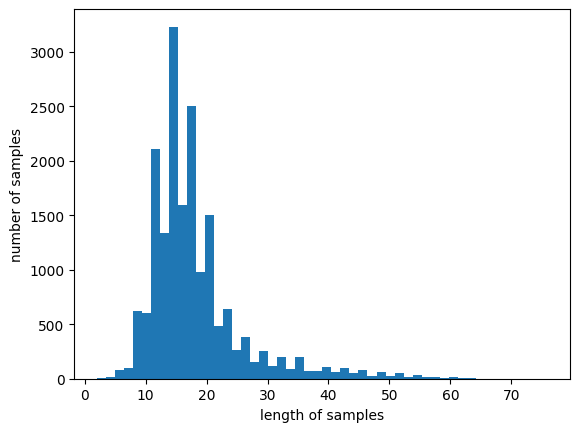

In [43]:
print(  '본문의 최대 길이 :',   max(   len(sent) for sent in X_train   )   )
# X_train 요소 하나하나 길이 재서 최대길이추출
print(   '본문의 평균 길이 :',  sum(    map(len, X_train)  )   /  len(X_train)     )
# X_train 요소 길이 재서 sum하구 X_train 개수로 나눈다
plt.hist([len(sent) for sent in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [44]:
max_len = 76

In [45]:
X_train_encoded = pad_sequences(X_train_encoded, maxlen=max_len)
X_test_encoded = pad_sequences(X_test_encoded, maxlen=max_len)

In [46]:
X_train_encoded.shape

(18292, 76)

In [47]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# 모델

In [51]:
embedding_dim = 64
hidden_units = 64
num_classes = 3

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(num_classes, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('../NLP/NLP/best_model2.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
history = model.fit(X_train_encoded, y_train, epochs=15, callbacks=[es, mc], batch_size=32, validation_split=0.2)

Epoch 1/15
458/458 [==============================] - ETA: 0s - loss: 0.5908 - acc: 0.7504
Epoch 1: val_acc improved from -inf to 0.84586, saving model to ../NLP/NLP\best_model2.h5
458/458 [==============================] - 19s 36ms/step - loss: 0.5908 - acc: 0.7504 - val_loss: 0.4005 - val_acc: 0.8459
Epoch 2/15
457/458 [============================>.] - ETA: 0s - loss: 0.2728 - acc: 0.8957
Epoch 2: val_acc improved from 0.84586 to 0.84914, saving model to ../NLP/NLP\best_model2.h5
458/458 [==============================] - 18s 39ms/step - loss: 0.2728 - acc: 0.8957 - val_loss: 0.3808 - val_acc: 0.8491
Epoch 3/15
457/458 [============================>.] - ETA: 0s - loss: 0.1461 - acc: 0.9474
Epoch 3: val_acc did not improve from 0.84914
458/458 [==============================] - 18s 39ms/step - loss: 0.1461 - acc: 0.9474 - val_loss: 0.4413 - val_acc: 0.8456
Epoch 4/15
458/458 [==============================] - ETA: 0s - loss: 0.0888 - acc: 0.9706
Epoch 4: val_acc did not improve from 

In [49]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test_encoded, y_test)[1]))

143/143 [==============================] - 2s 8ms/step - loss: 0.5127 - acc: 0.8458

 테스트 정확도: 0.8458
